# Cybersecurity Attacks Detection Dataset

**This dataset contains 9,537 records of network activity with a unique session ID (session_id) and 10 features used for intrusion detection. It includes attributes like packet size, protocol type, login attempts, session duration, encryption type, IP reputation score,failed logins, browser type, unusual time access along with attack detection data.**

### Cybersecurity Dataset Feature Breakdown

| Feature Category       | Feature Name            | Description | Possible Values/Range | Attack Indicators |
|------------------------|-------------------------|-------------|-----------------------|-------------------|
| **Network-Based**      | network_packet_size     | Packet size in bytes. Small packets (~64B) may indicate control messages; large packets (~1500B) suggest data transfer. | 64–1500 bytes | Abnormally small/large packets for exploitation. |
|                        | protocol_type           | Communication protocol used. | TCP, UDP, ICMP | ICMP often abused in DoS attacks. |
|                        | encryption_used         | Encryption method applied. | AES, DES, None | Weak (DES) or no encryption raises risk. |
| **User Behavior-Based**| login_attempts          | Number of login attempts. | Integer (e.g., 1–3 normal) | High values suggest brute-force attacks. |
|                        | session_duration        | Length of active session in seconds. | Seconds | Long durations may indicate unauthorized access. |
|                        | failed_logins           | Count of failed login attempts. | Integer | High counts signal credential stuffing. |
|                        | unusual_time_access     | Flag for logins outside typical hours. | 0 (normal), 1 (unusual) | Attacks often occur off-hours. |
|                        | ip_reputation_score     | Trust score of the IP (higher = more suspicious). | 0–1 | High scores link to botnets/spam. |
|                        | browser_type            | Browser used in the session. | Chrome, Firefox, Edge, Safari, Unknown | "Unknown" may indicate bots. |
| **Target Variable**    | attack_detected         | Binary label for attacks. | 0 (normal), 1 (attack) | Supervised learning target. |

*Along with ***attack_detected*** which is used in classification model, the ***session_duration*** variable is also considered as a target variable for the regression model in this analysis.*

**Type of Problem**: Classification and Regression.

**Source: https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset/data**

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,f1_score,recall_score,precision_recall_curve,roc_curve
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, KFold

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Data Preprocessing and Cleaning

In [3]:
cyber = pd.read_csv('C:/Users/harig/Downloads/Data Mining and Machine Learning/Final_DM/Data/cybersecurity_intrusion_data.csv',encoding='latin-1')

In [4]:
cyber.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.98,DES,0.61,1,Edge,0,1
1,SID_00002,472,TCP,3,1558.00,DES,0.30,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.04,DES,0.74,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.25,DES,0.12,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.54,AES,0.05,1,Firefox,0,0


In [5]:
print("Dimensions of the dataset:")
cyber.shape

Dimensions of the dataset:


(9537, 11)

In [6]:
print("Dataset statistical summary:")
cyber.describe()

Dataset statistical summary:


,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.00,9537.00,9537.00,9537.00,9537.00,9537.00,9537.00
mean,500.43,4.03,792.75,0.33,1.52,0.15,0.45
std,198.38,1.96,786.56,0.18,1.03,0.36,0.50
min,64.00,1.00,0.50,0.00,0.00,0.00,0.00
25%,365.00,3.00,231.95,0.19,1.00,0.00,0.00
50%,499.00,4.00,556.28,0.31,1.00,0.00,0.00
75%,635.00,5.00,1105.38,0.45,2.00,0.00,1.00
max,1285.00,13.00,7190.39,0.92,5.00,1.00,1.00


In [7]:
print("Variable Datatypes:")
cyber.dtypes

Variable Datatypes:


session_id              object
network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object

In [8]:
print("Null Values in the dataset:")
cyber.isna().sum()

Null Values in the dataset:


session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64

In [9]:
cyber.dropna(inplace=True)

In [10]:
cyber.isna().sum()

session_id             0
network_packet_size    0
protocol_type          0
login_attempts         0
session_duration       0
encryption_used        0
ip_reputation_score    0
failed_logins          0
browser_type           0
unusual_time_access    0
attack_detected        0
dtype: int64

***Splitting the columns based on the value type***

In [11]:
numeric_cols = cyber.columns[(cyber.dtypes == int)|(cyber.dtypes==float)]
print("These are the numeric columns in the dataset:")
numeric_cols

These are the numeric columns in the dataset:


Index(['network_packet_size', 'login_attempts', 'session_duration',
       'ip_reputation_score', 'failed_logins', 'unusual_time_access',
       'attack_detected'],
      dtype='object')

In [12]:
categorical_cols = cyber.columns[(cyber.dtypes != int) & (cyber.dtypes != float)]
print("These are the categorical columns")
categorical_cols

These are the categorical columns


Index(['session_id', 'protocol_type', 'encryption_used', 'browser_type'], dtype='object')

# Exploratory Data Analysis

##### Visualizations

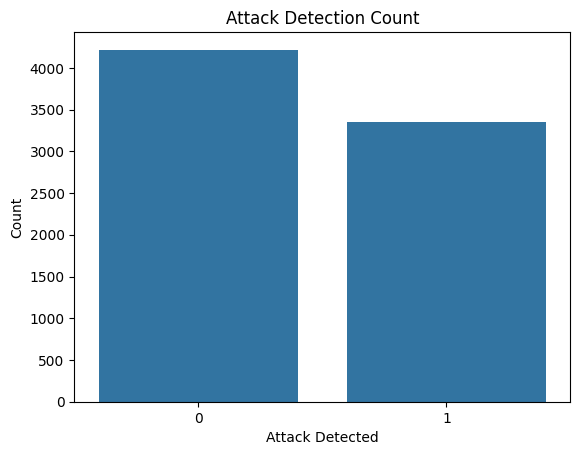

In [13]:
sns.countplot(x='attack_detected', data=cyber)
plt.title('Attack Detection Count')
plt.xlabel('Attack Detected')
plt.ylabel('Count')
plt.show()

*Even though attack_detection target variable has class imbalance, it is very mild and does not require balancing*

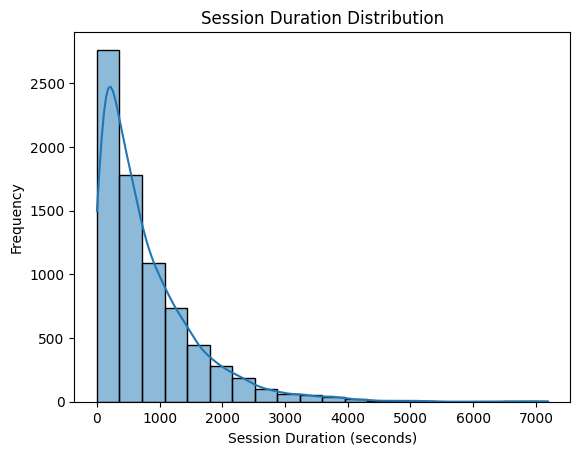

In [14]:
sns.histplot(cyber['session_duration'], kde=True, bins=20)
plt.title('Session Duration Distribution')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

*Session Duration is highly skewed, log transformation should be applied before regression for stablization since it can affect model performance.*

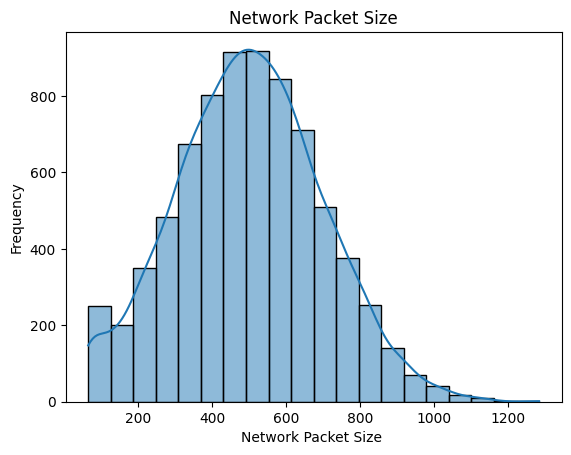

In [15]:
sns.histplot(cyber['network_packet_size'], kde=True, bins=20)
plt.title('Network Packet Size')
plt.xlabel('Network Packet Size ')
plt.ylabel('Frequency')
plt.show()

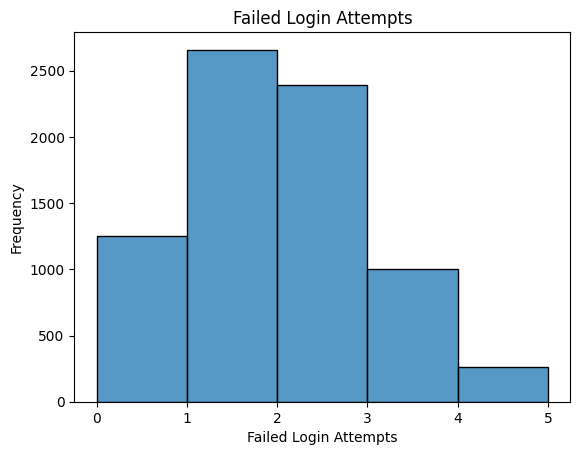

In [16]:
sns.histplot(cyber['failed_logins'], bins=5)
plt.title('Failed Login Attempts')
plt.xlabel('Failed Login Attempts')
plt.ylabel('Frequency')
plt.show()

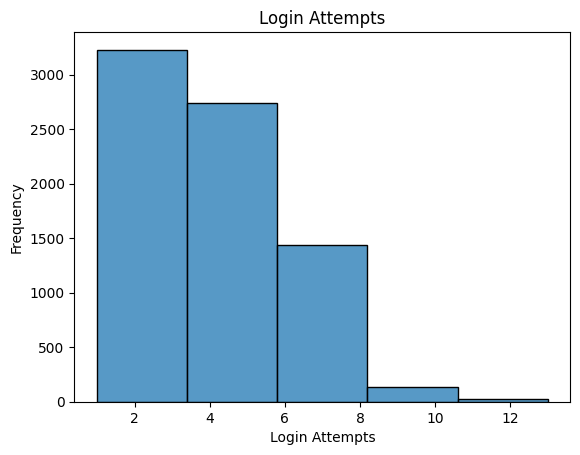

In [17]:
sns.histplot(cyber['login_attempts'], bins=5)
plt.title('Login Attempts')
plt.xlabel('Login Attempts')
plt.ylabel('Frequency')
plt.show()

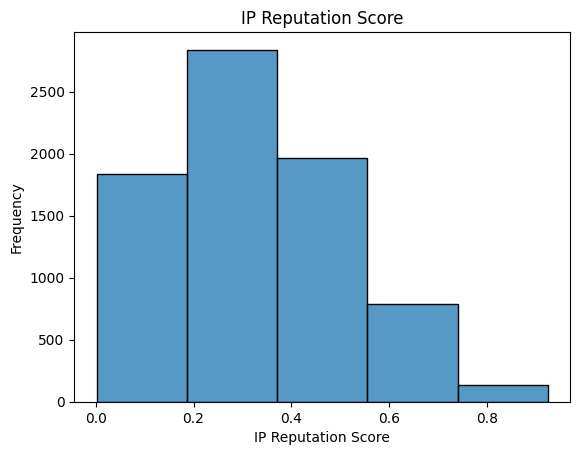

In [18]:
sns.histplot(cyber['ip_reputation_score'], bins=5)
plt.title('IP Reputation Score')
plt.xlabel('IP Reputation Score')
plt.ylabel('Frequency')
plt.show()

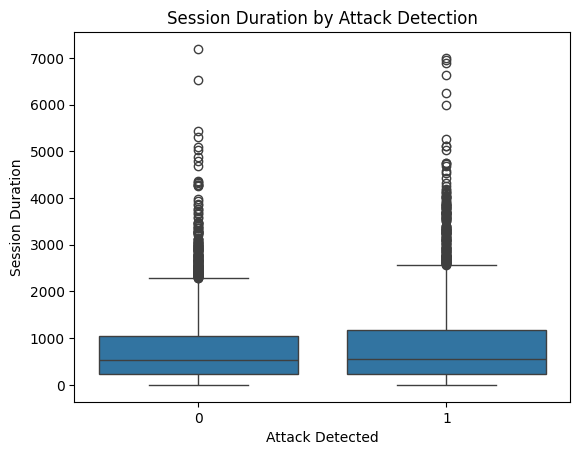

In [19]:
sns.boxplot(x='attack_detected', y='session_duration', data=cyber)
plt.title('Session Duration by Attack Detection')
plt.xlabel('Attack Detected')
plt.ylabel('Session Duration')
plt.show()

*Since session duration is used for classification and regression model and has multiple outliers, this can be normalized*

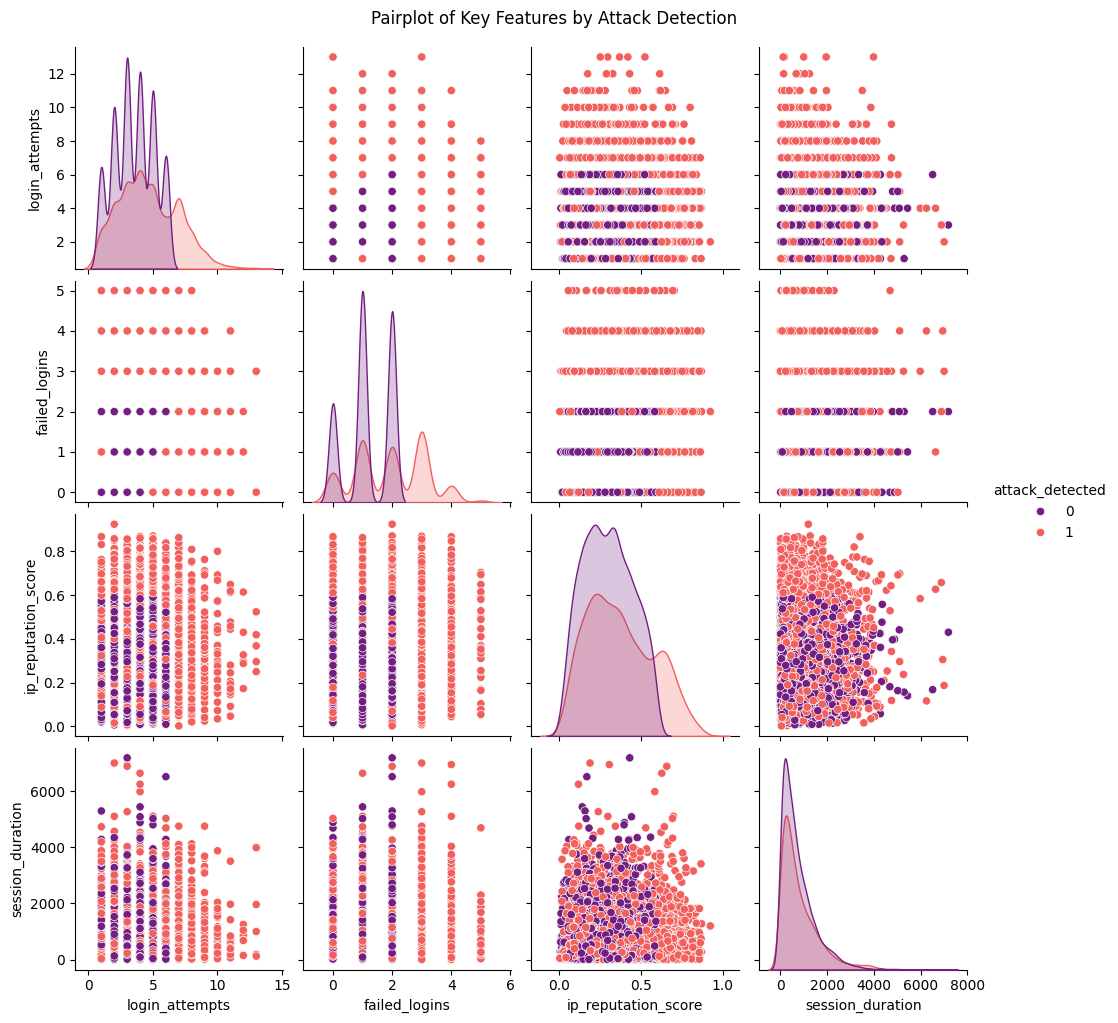

In [20]:
sns.pairplot(cyber[['login_attempts', 'failed_logins', 'ip_reputation_score', 'session_duration', 'attack_detected']],
             hue='attack_detected', palette='magma')
plt.suptitle('Pairplot of Key Features by Attack Detection', y=1.02)
plt.show()


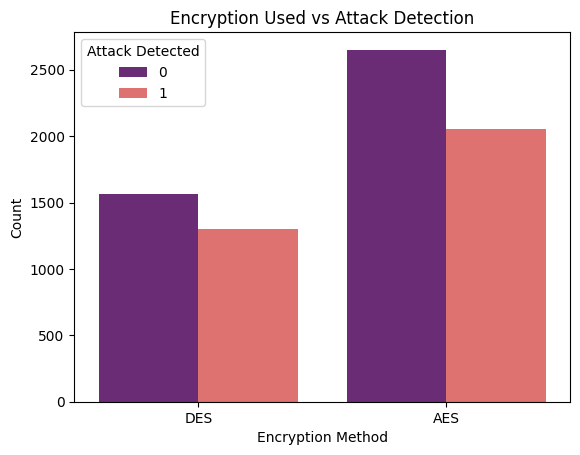

In [21]:
sns.countplot(x='encryption_used', hue='attack_detected', data=cyber, palette='magma')
plt.title('Encryption Used vs Attack Detection')
plt.xlabel('Encryption Method')
plt.ylabel('Count')
plt.legend(title='Attack Detected')
plt.show()


##### Feature Engineering

In [22]:
cyber['failure_ratio'] = cyber['failed_logins'] / (cyber['login_attempts'] + 1e-6)
cyber['session_intensity'] = cyber['login_attempts'] / (cyber['session_duration'] + 1e-6)
cyber['login_attempt_score'] = cyber['login_attempts'] * cyber['ip_reputation_score']
cyber['login_fail_score'] = cyber['failed_logins'] * cyber['ip_reputation_score']

These newly engineered features aim to capture patterns related to login behavior and potential attack signals. failure_ratio and session_intensity reflect login efficiency and attempt frequency, while login_attempt_score and login_fail_score combine activity volume with risk (via ip_reputation_score), helping identify high-risk sessions.

In [23]:
cyber['log_session_duration'] = np.log1p(cyber['session_duration'])

*Normalizing session_duration variable*

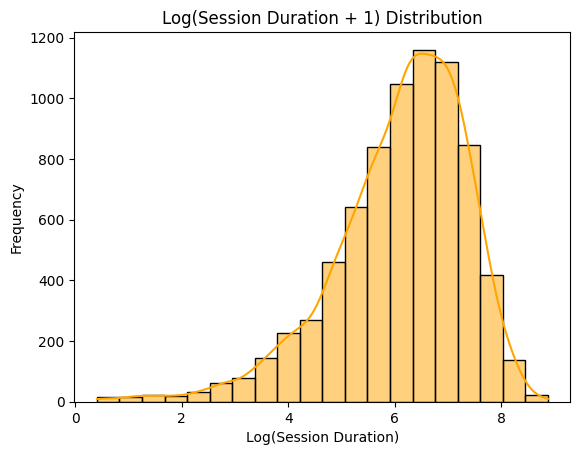

In [24]:
sns.histplot(cyber['log_session_duration'], kde=True, bins=20, color='orange')
plt.title('Log(Session Duration + 1) Distribution')
plt.xlabel('Log(Session Duration)')
plt.ylabel('Frequency')
plt.show()

In [25]:
scaler = StandardScaler()
cyber['log_session_duration_std'] = scaler.fit_transform(cyber[['log_session_duration']])

In [26]:
cyber.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected,failure_ratio,session_intensity,login_attempt_score,login_fail_score,log_session_duration,log_session_duration_std
0,SID_00001,599,TCP,4,492.98,DES,0.61,1,Edge,0,1,0.25,0.01,2.43,0.61,6.20,0.07
1,SID_00002,472,TCP,3,1558.00,DES,0.30,0,Firefox,0,0,0.00,0.00,0.90,0.00,7.35,0.99
2,SID_00003,629,TCP,3,75.04,DES,0.74,2,Chrome,0,1,0.67,0.04,2.22,1.48,4.33,-1.42
3,SID_00004,804,UDP,4,601.25,DES,0.12,0,Unknown,0,1,0.00,0.01,0.49,0.00,6.40,0.23
4,SID_00005,453,TCP,5,532.54,AES,0.05,1,Firefox,0,0,0.20,0.01,0.27,0.05,6.28,0.14


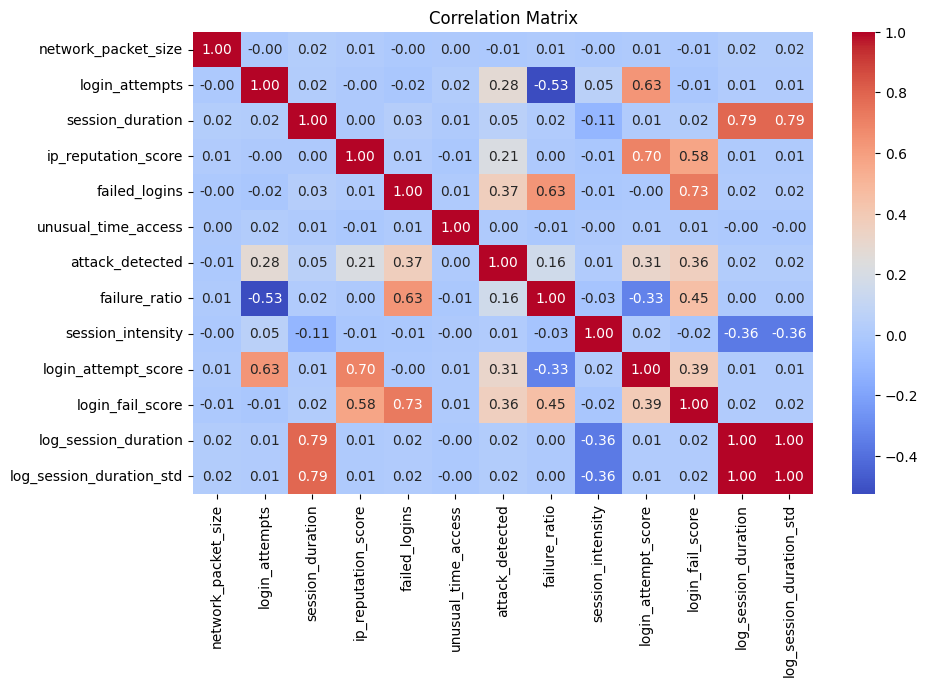

In [27]:
plt.figure(figsize=(10, 6))
sns.heatmap(cyber.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

***Encoding categorical variables using Label Encoder***

In [28]:
lEncoder = LabelEncoder()
cyber['encryption_used'] = lEncoder.fit_transform(cyber['encryption_used'])
cyber['protocol_type'] = lEncoder.fit_transform(cyber['protocol_type'])
cyber['browser_type'] = lEncoder.fit_transform(cyber['browser_type'])

***Dropping un-necessary variables***

In [29]:
cyber.drop(columns=['session_duration','session_id'],inplace=True)

# Models

The models implemented in this analysis are Support Vector Machine Classifier and Random Forest Regressor.

These are the respective target variables respectively:
+ ***attack_detected*** (SVM)
+ ***log_session_duration*** (Random Forest Regressor)

**The two target variables are used in-order to answer two different problems.**  

##### Support Vector Machine Classifier

***Classification Task**: Detecting Attacks (attack_detected)*  
***Target variable**: attack_detected (binary: 0 = no attack, 1 = attack)*  
***Goal**: Predict whether a session is an attack or not.*  
***Model used**: SVM*  
***Type of problem**: Supervised Classification*  

In [30]:
X = cyber.drop(columns=['attack_detected','log_session_duration'],axis=1)
y = cyber['attack_detected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_model = make_pipeline(StandardScaler(), SVC(probability=True, kernel='rbf'))
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]


In [32]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


Confusion Matrix:
[[1206   54]
 [ 270  742]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1260
           1       0.93      0.73      0.82      1012

    accuracy                           0.86      2272
   macro avg       0.87      0.85      0.85      2272
weighted avg       0.87      0.86      0.85      2272

ROC AUC Score: 0.8677512704686619
Accuracy: 0.8573943661971831
F1 Score: 0.8207964601769911
Recall: 0.733201581027668


***Threshold Tuning***

In [33]:
threshold = 0.3
y_pred_thresh = (y_prob >= threshold).astype(int)

In [34]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_thresh))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("Accuracy:", accuracy_score(y_test, y_pred_thresh))
print("F1 Score:", f1_score(y_test, y_pred_thresh))
print("Recall:", recall_score(y_test, y_pred_thresh))


Confusion Matrix:
[[1006  254]
 [ 207  805]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1260
           1       0.76      0.80      0.78      1012

    accuracy                           0.80      2272
   macro avg       0.79      0.80      0.80      2272
weighted avg       0.80      0.80      0.80      2272

ROC AUC Score: 0.8677512704686619
Accuracy: 0.7970950704225352
F1 Score: 0.7774022211492033
Recall: 0.7954545454545454


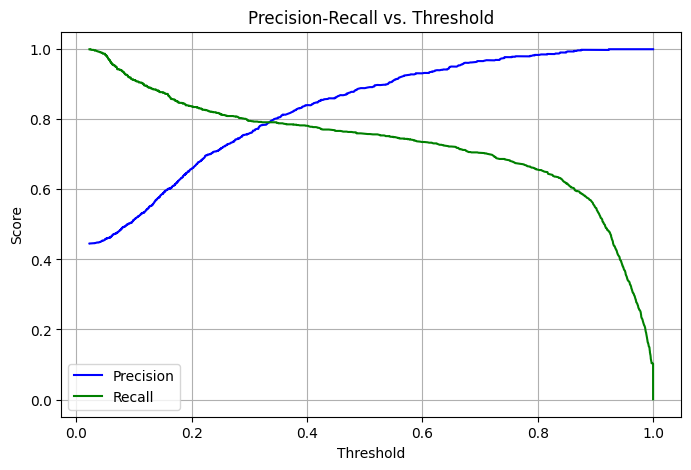

In [35]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

***ROC AUC Curve***

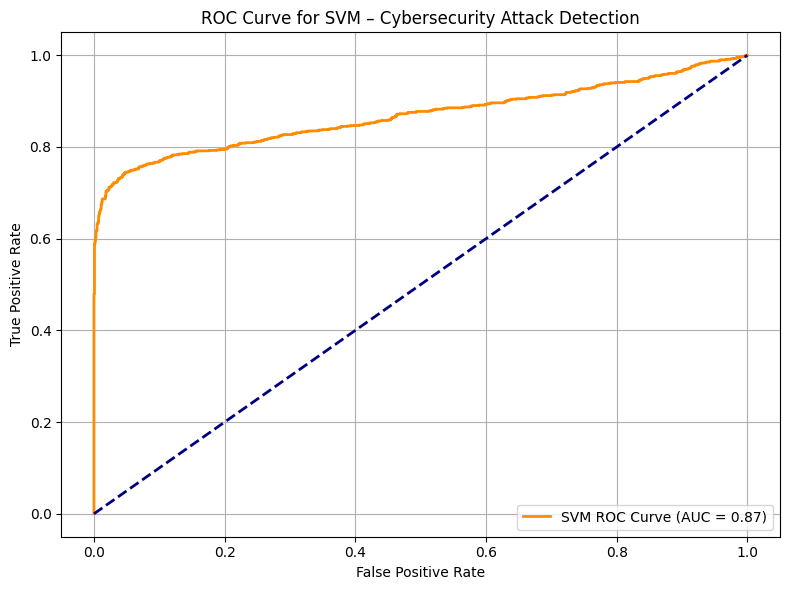

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# 4. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'SVM ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM – Cybersecurity Attack Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

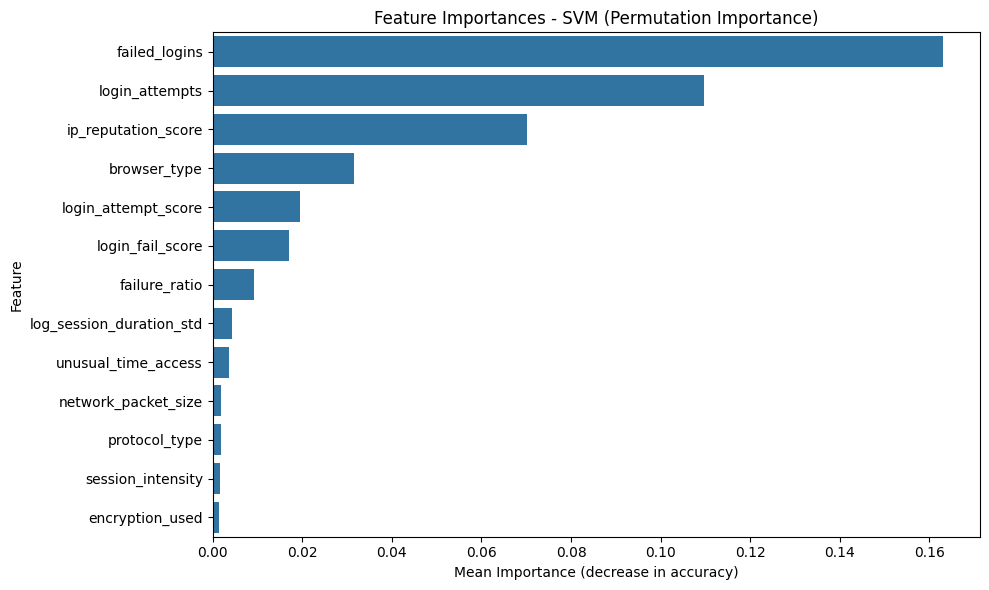

In [37]:
result = permutation_importance(svm_model, X, y, n_repeats=10, random_state=42, scoring='accuracy')
importances_svm = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances_svm, y=importances_svm.index)
plt.title("Feature Importances - SVM (Permutation Importance)")
plt.xlabel("Mean Importance (decrease in accuracy)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

##### Random Forest Regressor

***Regression Task**: Predicting Session Duration (session_duration)*  
***Target variable**: log_session_duration (continuous numeric value)*  
***Goal**: Estimate how long a session is likely to last.*  [A higher session time, probably indicates an attack scenario.]  
***Model used**: Decision Tree Regressor, Random Forest Regressor, etc.*  
***Type of problem**: Supervised Regression*  

In [38]:
X = cyber.drop(columns=['log_session_duration_std','log_session_duration'],axis=1)
y = cyber['log_session_duration']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 0.0010453803308243244


***Residual Plot***

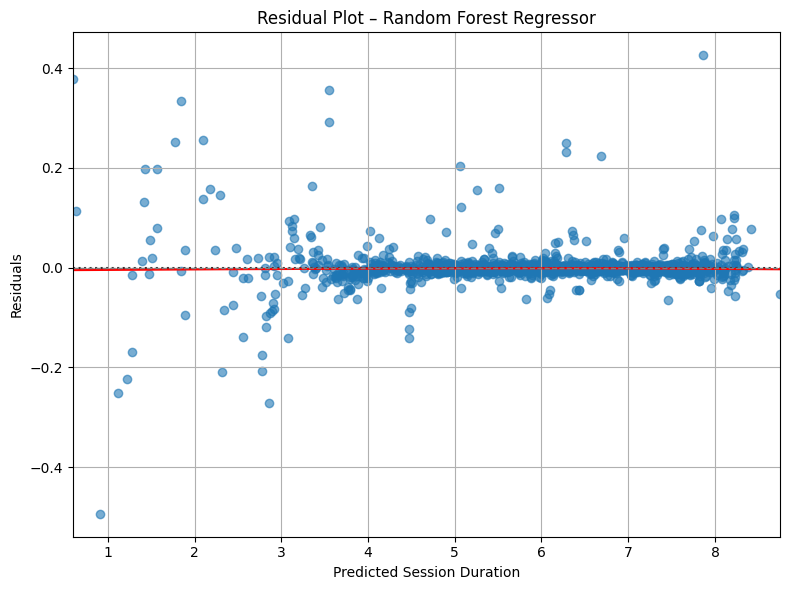

In [41]:
residuals = y_test - y_pred

# Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, 
              line_kws={'color': 'red', 'lw': 1.5}, 
              scatter_kws={'alpha': 0.6})
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.xlabel('Predicted Session Duration')
plt.ylabel('Residuals')
plt.title('Residual Plot – Random Forest Regressor')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
mse_scores = -neg_mse_scores
rmse_scores = np.sqrt(mse_scores)

print("Cross-validated MSE scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("Mean RMSE:", rmse_scores.mean())

Cross-validated MSE scores: [0.00048082 0.00132828 0.00182701 0.00123238 0.00169844]
Mean MSE: 0.0013133856418545405
Mean RMSE: 0.03548681320476162


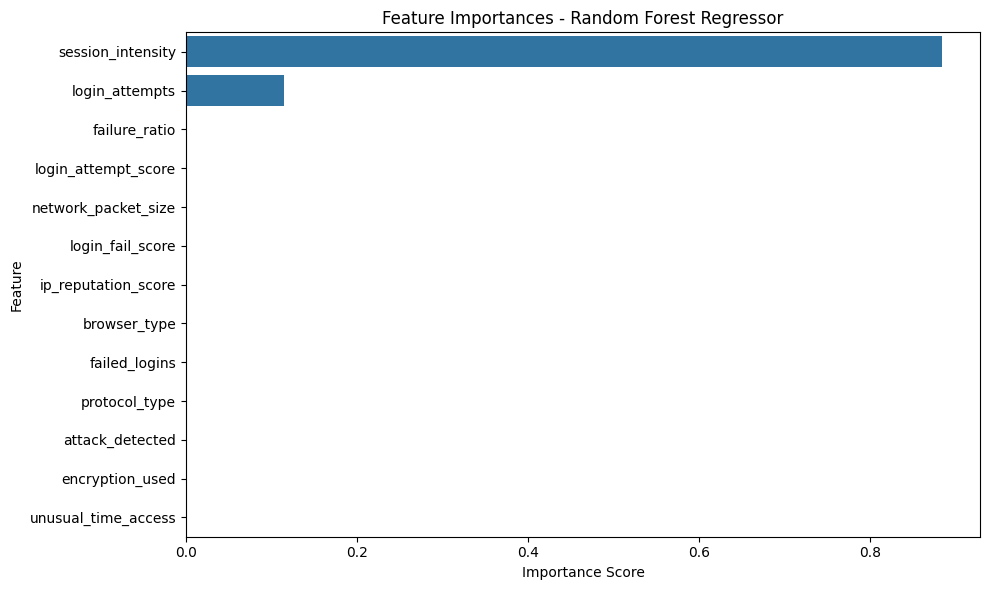

In [43]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importances - Random Forest Regressor")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()